"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [19]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import numpy as np
from scipy.stats import poisson
import sys
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
import visualize as vz

In [3]:
def var_sig_np(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+np.exp(-b*x))

def var_sig_exp_np(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+np.exp(-np.exp(b)*x))


In [29]:
max_x = 20
x = np.linspace(0,max_x,100)
idx = np.arange(len(x))
states = 3
nrns = 7
trials = 10


# #b = [20,1]
# b = [20,1]#stats.norm.rvs(0,2, size=states-1)
# inflect = [-3,5]
# min_val = stats.expon.rvs(10, size=nrns)#3
# val_diff = stats.norm.rvs(0,30,size=(nrns,states-1))#[40,-20]

#b = [20,1]
b = [20,1]#stats.norm.rvs(0,2, size=states-1)
inflect = np.random.random((trials, states-1))*max_x#[-3,5]
min_val = stats.expon.rvs(10, size=nrns)#3
val_diff = stats.norm.rvs(0,30,size=(nrns,states-1))#[40,-20]

def gen_nrn(min_val, diff, inflect, b):
    rate = np.ones(len(x))*min_val
    for this_b, this_diff, this_inflect in zip(b,diff,inflect):
         rate += var_sig_np(x-this_inflect,this_b)*this_diff
    return rate


def gen_trial(min_val, val_diff, inflect, b):
    rate = []
    for i in range(nrns):
        this_min = min_val[i]
        this_diff = val_diff[i]
        rate.append(gen_nrn(this_min, this_diff, inflect, b))
    rate = np.stack(rate)
    return rate

rate = []
for i in range(trials):
    rate.append(
            gen_trial(min_val, val_diff, inflect[i], b)
    )
rate = np.stack(rate)
        
rate[rate<0] = 0
rate+=0.1
data_vec = poisson.rvs(rate)

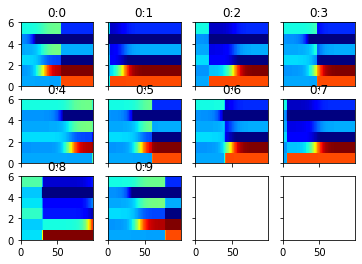

In [22]:
vz.firing_overview(rate);

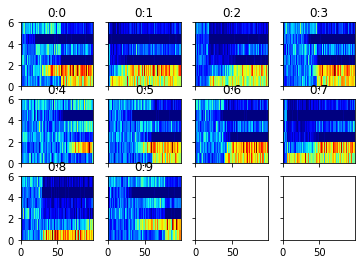

In [23]:
vz.firing_overview(data_vec);

In [24]:
def var_sig_exp_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-tt.exp(b)*x))

def var_sig_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-b*x))


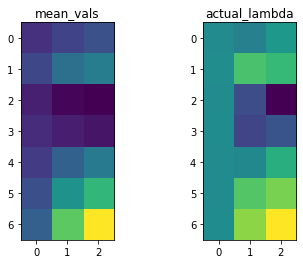

In [35]:
actual_lambda = np.cumsum(np.concatenate([min_val[:,None],val_diff],axis=-1),axis=-1)
mean_vals = np.mean([np.mean(x,axis=-1) for x in np.array_split(data_vec,states,axis=-1)],axis=1).T
#mean_vals.shape
#print(mean_vals)
fig,ax = plt.subplots(1,2)
ax[0].imshow(mean_vals);
ax[1].imshow(actual_lambda);
ax[0].set_title('mean_vals');
ax[1].set_title('actual_lambda');
# plt.show()

In [36]:
#from itertools import accumulate as acc
#lambda_test_vals = np.array(list(acc(mean_vals, np.subtract)))
lambda_test_vals = np.diff(mean_vals, axis=-1)
lambda_test_vals

array([[ 4.32959002,  3.48787879],
       [11.42433155,  4.3030303 ],
       [-5.59545455, -1.15454545],
       [-3.14714795, -2.26666667],
       [10.51301248,  7.84545455],
       [20.25606061, 11.33333333],
       [33.37254902, 18.94242424]])

In [37]:
even_switches = np.linspace(0,1,states+1)[1:-1]
even_switches

array([0.33333333, 0.66666667])

In [38]:
with pm.Model() as model:
      
    sig_b = pm.Normal('sig_b', -1,2, shape = states-1)
    #sig_b = pm.HalfCauchy('sig_b', 2, testval = 0.1)
    
    # Finite, but somewhere on the lower end, Beta prior
    
    s0 = pm.Exponential('state0', 
                        1/(np.mean(mean_vals)),
                        shape = nrns,
                        testval = mean_vals[:,0])
    
    lambda_diff = pm.Normal('lambda_diff', 
                            mu = 0, sigma = 10, 
                            shape = (nrns,states-1), 
                            testval = lambda_test_vals)#,
                                  #testval = mean_vals + 1e-3)

In [39]:
with model:
    a = pm.HalfCauchy('a_tau', 10, shape = states - 1)
    b = pm.HalfCauchy('b_tau', 10, shape = states - 1)
    
    #tau_latent = pm.Beta('tau_latent', 2, 5, 
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (trials, states-1)).sort(axis=-1)    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [58]:
idx_temp = np.tile(idx[None,None,:], (trials, states-1,1))
idx_temp.shape

(10, 2, 100)

In [47]:
with model:
    tau_temp = tt.tile(tau[:,:,None], (1,1,len(idx)))
tau_temp.tag.test_value.shape

(10, 2, 100)

In [54]:
sig_b.tag.test_value.shape

(2,)

In [56]:
with model:
    sig_b_temp = tt.tile(sig_b[None,:,None], (trials,1,len(idx)))
sig_b_temp.tag.test_value.shape

(10, 2, 100)

In [60]:
with model:
    weight_stack = var_sig_exp_tt(idx_temp-tau_temp,sig_b_temp)
    #weight1 = var_sig_exp_tt(idx-tau,sig_b[0])
    #weight2 = var_sig_exp_tt(idx-tau,sig_b[1])
#     weight_stack = tt.stack([weight1,weight2])
#     weight_stack_temp = tt.tile(weight_stack[None,:,:],(nrns,1,1))
# weight_stack_temp.tag.test_value.shape
weight_stack.tag.test_value.shape

(10, 2, 100)

In [67]:
with model:
    weight_stack_temp = tt.tile(weight_stack[:,None,:,:], (1,nrns,1,1))
weight_stack_temp.tag.test_value.shape

(10, 7, 2, 100)

In [61]:
s0.tag.test_value.shape

(7,)

In [64]:
with model:
    s0_temp = tt.tile(s0[None,:,None,None], (trials,1,states-1, len(idx)))
s0_temp.tag.test_value.shape

(10, 7, 2, 100)

In [65]:
with model:
    lambda_diff_temp = tt.tile(lambda_diff[None,:,:,None], (trials,1,1, len(idx)))
lambda_diff_temp.tag.test_value.shape

(10, 7, 2, 100)

In [68]:
with model:
    
    lambda_ =  pm.Deterministic('lambda_',
                    tt.sum(s0_temp + (weight_stack_temp*lambda_diff_temp),axis=2))
    lambda_bounded = pm.Deterministic("lambda_bounded", tt.switch(lambda_>=0, lambda_, 0))
    
    #     weight_stack = var_sig_exp_tt(idx[np.newaxis,:]-tau[:,np.newaxis],sig_b)
    #     #weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    #     weight_stack = tt.concatenate([np.ones((1,fin_length)),weight_stack],axis=0)
    #     inverse_stack = 1 - weight_stack[1:]
    #     inverse_stack = tt.concatenate([inverse_stack, np.ones((1,fin_length))],axis=0)
    #     weight_stack = np.multiply(weight_stack,inverse_stack)
    # lambda_ = pm.math.sum(np.multiply(weight_stack,lambda_latent[:,np.newaxis]),axis=0)

In [69]:
lambda_bounded.tag.test_value.shape

(10, 7, 100)

/media/bigdata/firing_space_plot/ephys_data/visualize.py:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  vmin = min_val[nrn], vmax = max_val[nrn])


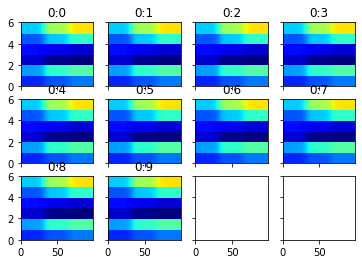

In [70]:
vz.firing_overview(lambda_bounded.tag.test_value);

In [71]:
# plt.imshow(weight_stack.tag.test_value,aspect='auto')

In [72]:
with model:
    # Add observations
    observation = pm.Poisson("obs", lambda_bounded, observed=data_vec)

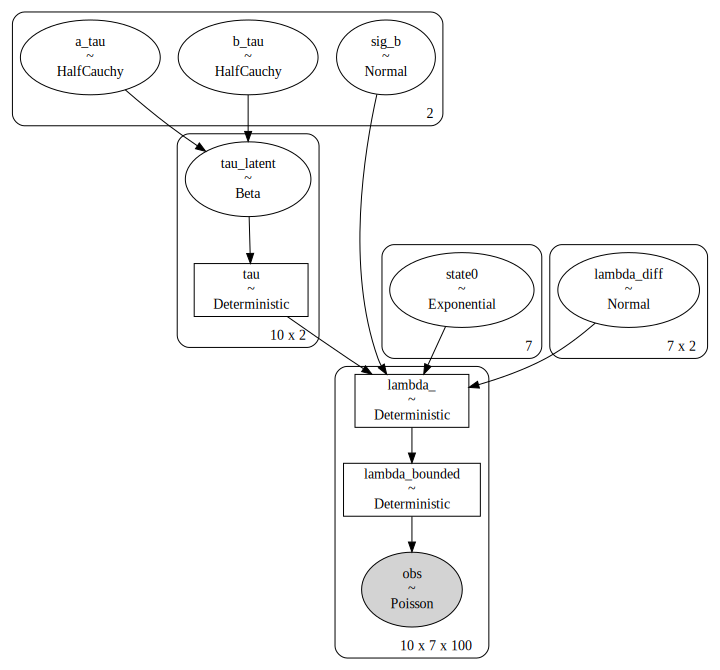

In [73]:
pm.model_to_graphviz(model)

In [74]:
fit = 40000
samples = 10000
with model:
    #     inference = pm.ADVI('full-rank')
    #     #     tracker = pm.callbacks.Tracker(
    #     #             mean=inference.approx.mean.eval,  # callable that returns mean
    #     #             std=inference.approx.std.eval,  # callable that returns std
    #     #         )
    #     approx = pm.fit(n=fit, method=inference)#,
    #     #                    callbacks=[tracker])
    #     trace = approx.sample(draws=samples)
    
    # If using MCMC, set n_cores = 1 (or whatever the parameter is) to make
    # sure there are no parallelization issues
    full_trace = pm.sample(draws=samples)
    trace = full_trace[::10]

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, b_tau, a_tau, lambda_diff, state0, sig_b]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 502 seconds.
There were 8715 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9427 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8470 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8083 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/plots/plot_utils.py:496: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (56268) in plot_autocorr, generating only 40 plots
  UserWarning,


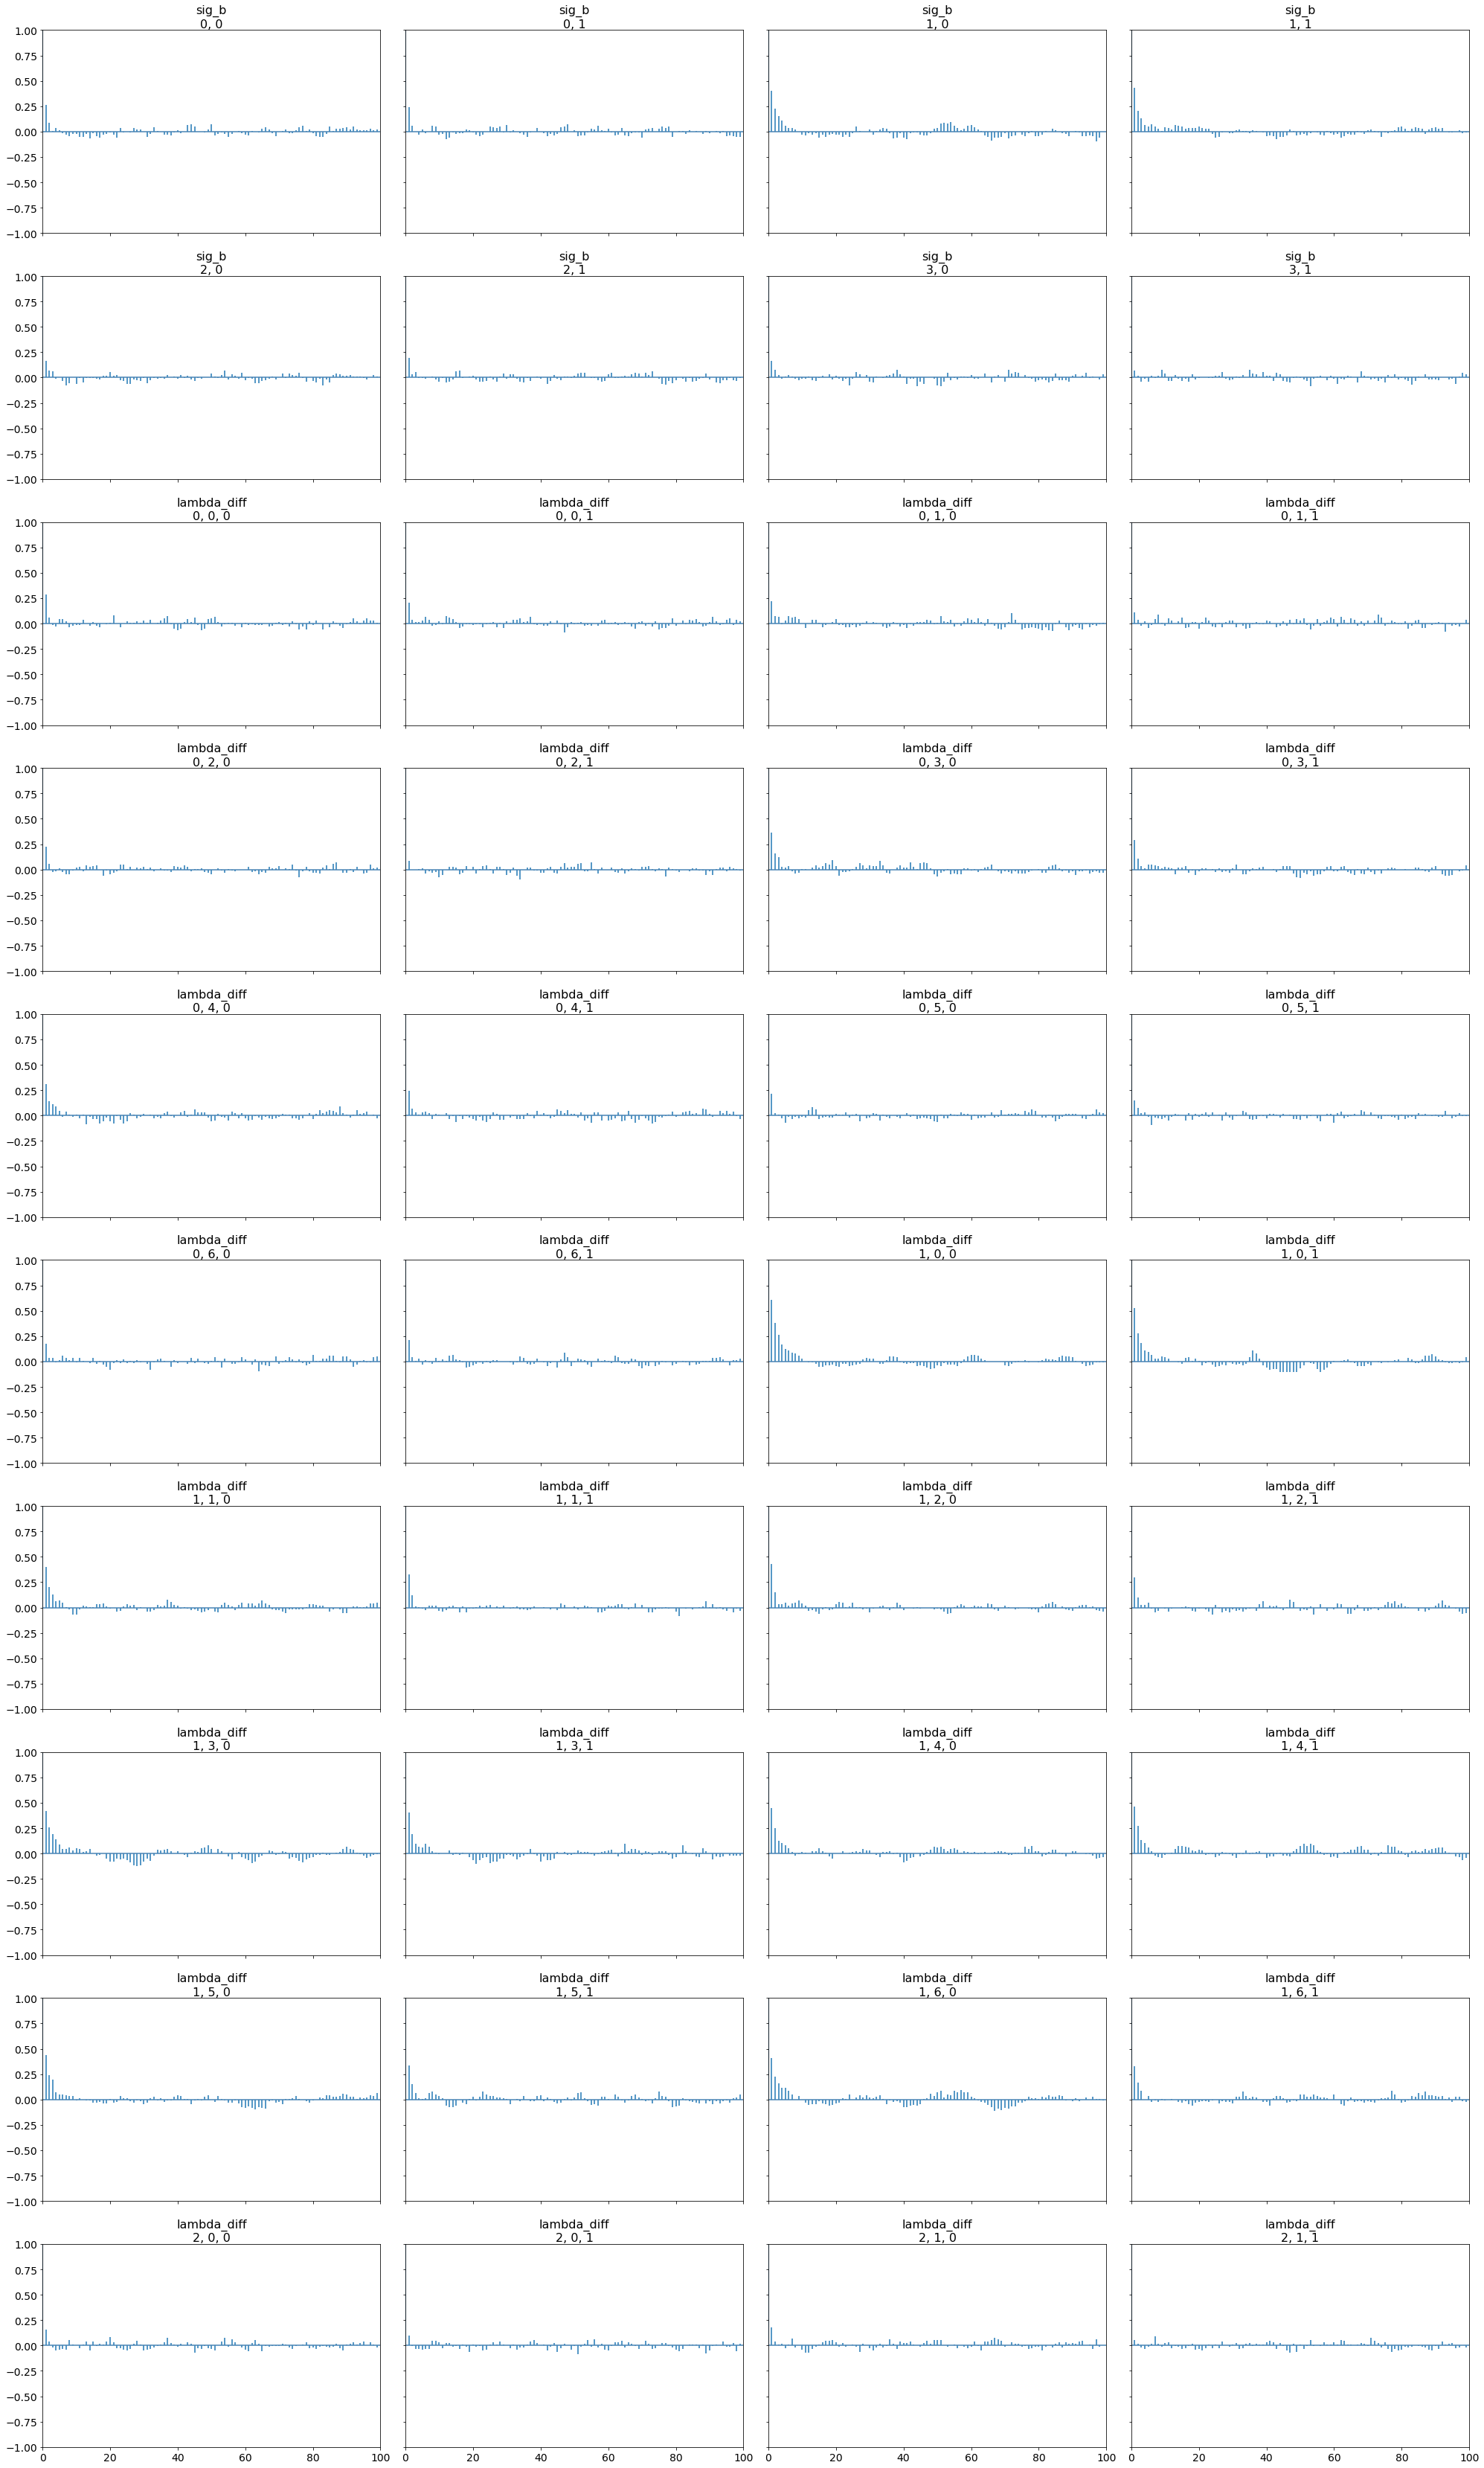

In [75]:
pm.autocorrplot(trace);

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/plots/__init__.py:36: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  f"Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8"


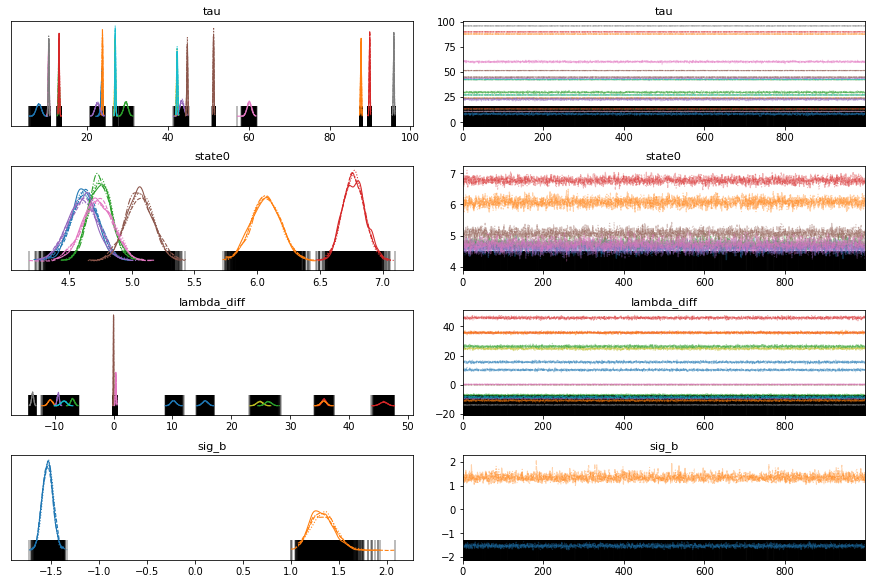

In [76]:
with model:
    pm.traceplot(trace, varnames = ['tau', 'state0', 'lambda_diff', 'sig_b'])

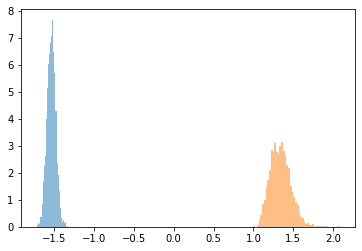

In [77]:
for x in trace['sig_b'].T:
    plt.hist(x,50, alpha=0.5, density=True);
#np.mean(trace['sig_b'])

In [78]:
np.power(10,np.mean(trace['sig_b'],axis=0))

array([ 0.02915407, 21.81059826])

In [79]:
np.power(10,np.diff(np.mean(trace['sig_b'],axis=0)))

array([748.11502404])

In [85]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)
mean_ppc = np.mean(ppc['obs'],axis=0)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [432]:
# fig,ax = plt.subplots(1,2,sharey=True)
# ax[0].plot(rate)
# ax[1].plot(np.mean(ppc['obs'],axis=0), alpha=1)
# ax[0].set_title('True r')
# ax[1].set_title('Mean prediction')

In [82]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
mode_tau

array([[23, 23],
       [13, 13],
       [43, 44],
       [60, 95],
       [42, 42],
       [ 8, 87],
       [29, 89],
       [22, 51],
       [10, 10],
       [27, 27]])

/media/bigdata/firing_space_plot/ephys_data/visualize.py:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  vmin = min_val[nrn], vmax = max_val[nrn])


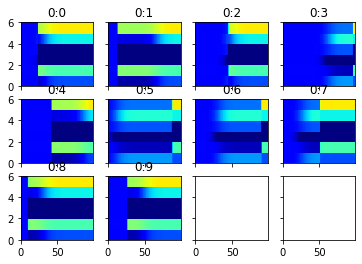

In [83]:
vz.firing_overview(rate);

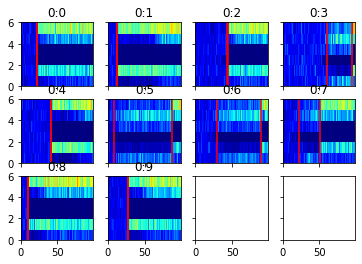

In [100]:
ax = vz.firing_overview(data_vec)
for this_ax, this_mode_tau in zip(ax.flatten(), mode_tau):
    for this_val in this_mode_tau:
        this_ax.axvline(this_val, color = 'red')

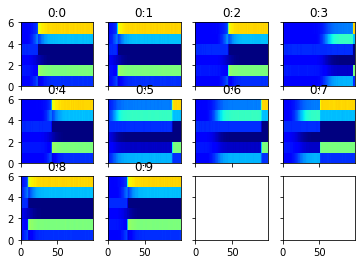

In [86]:
vz.firing_overview(mean_ppc);

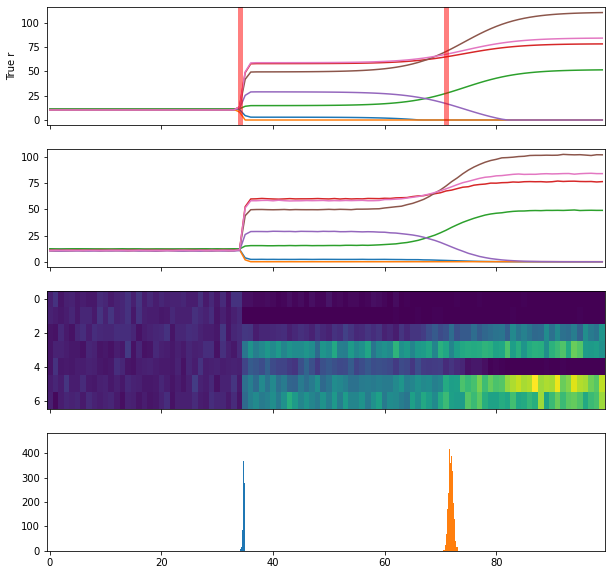

In [434]:
fig,ax = plt.subplots(4,1,sharex=True,figsize=(10,10))
#ax[0].imshow(rate, interpolation='nearest', aspect='auto')
ax[0].plot(rate.T)
ax[0].set_ylabel('True r')
#ax[1].imshow(np.mean(ppc['obs'],axis=0), interpolation='nearest', aspect='auto')
ax[1].plot(.T)
ax[2].imshow(data_vec, interpolation='nearest', aspect='auto')
    
for tau_num, this_tau in enumerate(tau.T):
    ax[3].hist(this_tau,bins=50)
    ax[0].axvline(mode_tau[tau_num],color='red',alpha=0.5,linewidth=5)
